<a href="https://colab.research.google.com/github/h-h0304/2024S-Ajou-ML/blob/main/HW3_%EB%AC%B8%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import seaborn as sns

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# pytorch 기초

pytorch의 장점은 backword를 자체적으로 수행할 수 있다는 것입니다.

아래의 코드는 2차원 데이터로 2차원의 weight와 1개의 bias 계산하는 예제입니다.

- (requires_grad=True) 가 설정된 tensor들은 자동으로 gradiant를 계산하고 저장합니다.

- loss_function을 통해 구해진 값에 대하여 .backword()를 수행하면 gradiant를 계산하게 됩니다.


In [4]:
import torch

X = torch.tensor([[1, 2], [2, 3], [3, 4], [4, 5]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

# Initialize weights and bias with requires_grad=True
w = torch.tensor([[0.0], [0.0]], dtype=torch.float32,requires_grad=True)
b = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)
def forward(X):
    return torch.matmul(X, w) + b

def loss(Y, Y_pred):
    return ((Y_pred - Y) ** 2).mean()

learning_rate = 0.01
n_iters = 100

for epoch in range(n_iters):
    Y_pred = forward(X)
    l = loss(Y, Y_pred)

    # gradiant 초기화
    w.grad = None
    b.grad = None

    # backward pass
    l.backward()

    # weights와 bias 업데이트
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {l.item()}')

print("Trained weights:", w)
print("Trained bias:", b)

Epoch 1, Loss: 30.0
Epoch 11, Loss: 0.20919689536094666
Epoch 21, Loss: 0.19499194622039795
Epoch 31, Loss: 0.18202099204063416
Epoch 41, Loss: 0.16991272568702698
Epoch 51, Loss: 0.15861006081104279
Epoch 61, Loss: 0.14805902540683746
Epoch 71, Loss: 0.13821005821228027
Epoch 81, Loss: 0.12901613116264343
Epoch 91, Loss: 0.12043396383523941
Trained weights: tensor([[0.8717],
        [0.8450]], requires_grad=True)
Trained bias: tensor([-0.0267], requires_grad=True)


아래의 예시는 위와 동일한 코드이지만, 편하게 사용할 수 있는 함수들입니다.

- 각 대응되는 부분들을 확인해보세요

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
# Define the data
X = torch.tensor([[1, 2], [2, 3], [3, 4], [4, 5]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

initial_weight = torch.tensor([[0.0, 0.0]], dtype=torch.float32)
initial_bias = torch.tensor([0.0], dtype=torch.float32)


LinearModel = nn.Linear(in_features=2, out_features=1, bias=True)  # linear layer
LinearModel.weight.data = initial_weight.clone() #동일한 결과를 위해 동일하게 초기화
LinearModel.bias.data = initial_bias.clone() #동일한 결과를 위해 동일하게 초기화


criterion = nn.MSELoss() # loss fucntion 정의


optimizer = optim.SGD(LinearModel.parameters(), lr=0.01) # optimizer 정의

# Training loop
n_iters = 100
for epoch in range(n_iters):

    Y_pred = LinearModel(X)


    loss = criterion(Y_pred, Y)

    optimizer.zero_grad() # gradiant 초기화
    loss.backward() # backword process
    optimizer.step() # weight (&bias) update

    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')


trained_weight, trained_bias = LinearModel.weight.data, LinearModel.bias.data
print("Trained weights:", trained_weight)
print("Trained bias:", trained_bias)


Epoch 1, Loss: 30.0
Epoch 11, Loss: 0.20919689536094666
Epoch 21, Loss: 0.19499194622039795
Epoch 31, Loss: 0.182020902633667
Epoch 41, Loss: 0.16991257667541504
Epoch 51, Loss: 0.15860998630523682
Epoch 61, Loss: 0.14805902540683746
Epoch 71, Loss: 0.13821005821228027
Epoch 81, Loss: 0.12901613116264343
Epoch 91, Loss: 0.12043388187885284
Trained weights: tensor([[0.8717, 0.8450]])
Trained bias: tensor([-0.0267])


#### GPU 사용

- 런타임 > 런타임 유형변경 > GPU 선택
- .to() method를 사용하여 GPU로 모델과 데이터를 올릴 수 있음
- .cuda() 를 사용하는 것도 가능


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LinearModel.to(device) # GPU로 올리기
print(LinearModel)

Linear(in_features=2, out_features=1, bias=True)


In [8]:
X = X.to(device) # data도 GPU로 올려야 연산 가능함

In [9]:
LinearModel(X)

tensor([[2.5349],
        [4.2516],
        [5.9683],
        [7.6850]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [10]:
LinearModel.cpu() # 다시 CPU로
X.cpu()

tensor([[1., 2.],
        [2., 3.],
        [3., 4.],
        [4., 5.]])

# 문제 1


- MNIST Dataset을 활용하여 손글씨 이미지(숫자)를 예측하는 모델을 만드세요.
- 해당 데이터는 0~9까지의 숫자를 가지고 있습니다.

In [11]:
# Load training data
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import random_split

MNIST 데이터를 데이터 로더에 넣어서 사용하면 미니 배치 단위로 꺼내 쓸 수 있습니다.

In [12]:
training_data = datasets.MNIST(
    root="data",
    train=True, # training data
    download=True,
    transform=v2.ToTensor() # 이미지를 tensor로 변형
)

val_size = 5000
train_size = len(training_data) - val_size
training_data, val_data = random_split(training_data, [train_size, val_size])

# Load test data
test_data = datasets.MNIST(
    root="data",
    train=False, # test data
    download=True,
    transform=v2.ToTensor() # 이미지를 tensor로 변형
)

# data loader
# train, test 각각의 data loader 생성
smaple_loader = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 37886270.45it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2257509.34it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 7259932.33it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 12533242.61it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [13]:
# train feature와 label을 train_loader로부터 가져오기
sample_features, sample_labels = next(iter(smaple_loader))
print(f"Feature batch shape: {sample_features.size()}")
print(f"Labels batch shape: {sample_labels.size()}")

Feature batch shape: torch.Size([1, 1, 28, 28])
Labels batch shape: torch.Size([1])


#### 이미지로 확인

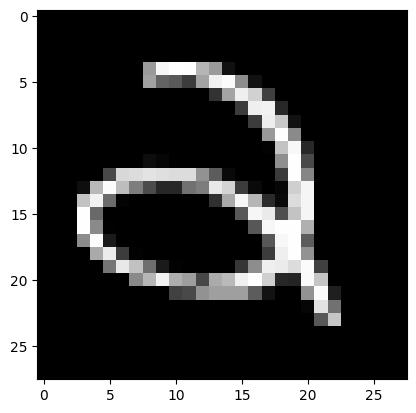

Label: 2


In [14]:
img = sample_features[0].squeeze()
label = sample_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 문제 1-1

MNIST 데이터셋을 아래의 조건에 따라 학습시키세요.

Fully connected layer (multi layer perceptron)로 NeuralNetwork를 아래의 조건에 맞게 완성하세요.

 - NeuralNetwork 모델 구축
    - 3개의 linear layer와 2개의 ReLU layer를 사용하세요.
    - nn.Linear, nn.ReLU
    - 각 layer의 hidden dimension size는 자유롭게 설정합니다.

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten() # 28x28 이미지를 784 픽셀 값의 배열로 변경
        self.linear_relu_stack = nn.Sequential(
            # 3개의 linear layer와 2개의 ReLU layer를 구성하세요
        #===================================================#
            nn.Linear(28*28, 512), # 첫 번째 Linear Layer: input feature 784 (28*28), output feature 512
            nn.ReLU(), # 첫 번째 ReLU Layer
            nn.Linear(512, 256), # 두 번째 Linear Layer: input feature 512, output feature 256
            nn.ReLU(), # 두 번째 ReLU Layer
            nn.Linear(256, 10), # 세 번째 Linear Layer: input feature 256, output feature 10 (클래스 개수)
        #===================================================#
        )

    def forward(self, x):
        # forward 함수 구현
        #===================================================#
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        #===================================================#
        return logits # forward 결과 저장

## 문제 1-2

위에서 만든 NeuralNetwork 모델을 학습시키세요.
train과 test함수를 만들세요.

- CrossEntropy 사용 (nn.CrossEntropyLoss)
- Epoch : 10, batch size : 32
- validation 정확도 90% 이상

In [16]:
# hyperparameter 설정
import torch.optim as optim
FcModel = NeuralNetwork()
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(FcModel.parameters(), lr=0.001, momentum=0.9) # optimizer

EPOCHS = 10 # the number of epochs
n_batch = 32 # the number of batches

# data loader의 batch size을 16로 변경
train_loader = torch.utils.data.DataLoader(training_data, batch_size=n_batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=n_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=n_batch, shuffle=True)

In [17]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler=None):
    size = 0
    num_batches = len(dataloader)

    model.train()
    epoch_loss , epoch_correct = 0 , 0

    for i ,(data_ , target_) in enumerate(dataloader):

        #===================================================#
        data_, target_ = data_.to('cuda'), target_.to('cuda')  # 데이터와 타겟을 GPU로 이동
        optimizer.zero_grad()  # 기울기를 0으로 초기화
        prediction = model(data_)  # 데이터를 모델에 전달하여 예측값을 계산
        loss = loss_fn(prediction, target_)  # 예측값과 실제값 사이의 손실 계산
        loss.backward()  # 손실에 대한 기울기 계산
        optimizer.step()  # 모델의 가중치 업데이트

        epoch_loss += loss.item()  # 에포크 손실 업데이트
        epoch_correct += (prediction.argmax(1) == target_).type(torch.float).sum().item()  # 정확한 예측 수 업데이트
        size += len(data_)
        #===================================================#

    if lr_scheduler != None:
        lr_scheduler.step()

    return epoch_correct/size , epoch_loss / num_batches

In [18]:
def test(dataloader , model , loss_fn):
    size = 0
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시
        for i, (data_ , target_) in enumerate(dataloader):

            #========================================#
            # 데이터와 타겟을 GPU로 이동
            data_, target_ = data_.to('cuda'), target_.to('cuda')
            prediction = model(data_)  # 데이터를 모델에 전달하여 예측값을 계산
            loss = loss_fn(prediction, target_)  # 예측값과 실제값 사이의 손실 계산
            epoch_loss += loss.item()
            epoch_correct += (prediction.argmax(1) == target_).type(torch.float).sum().item()
            size += len(data_)
            #========================================#

    return epoch_correct/size  , epoch_loss / num_baches

In [19]:
!mkdir checkpoints
FcModel.cuda()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [20]:
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   FcModel ,
                                   criterion ,
                                   optimizer )

    val_acc , val_loss = test(val_loader , FcModel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')


    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(FcModel.state_dict() , "checkpoints/NN_best.pth")

 10%|█         | 1/10 [00:11<01:47, 11.91s/it]

epoch:0     train_loss = 1.1654 , train_acc:0.7155     val_loss = 0.4419 , val_acc:0.8828     learning rate: 0.001


 20%|██        | 2/10 [00:22<01:27, 10.95s/it]

epoch:1     train_loss = 0.3756 , train_acc:0.8945     val_loss = 0.3271 , val_acc:0.9088     learning rate: 0.001


 30%|███       | 3/10 [00:32<01:15, 10.83s/it]

epoch:2     train_loss = 0.3083 , train_acc:0.9118     val_loss = 0.2848 , val_acc:0.9216     learning rate: 0.001


 40%|████      | 4/10 [00:43<01:05, 10.90s/it]

epoch:3     train_loss = 0.2700 , train_acc:0.9225     val_loss = 0.2505 , val_acc:0.9294     learning rate: 0.001


 50%|█████     | 5/10 [00:54<00:54, 10.96s/it]

epoch:4     train_loss = 0.2397 , train_acc:0.9309     val_loss = 0.2273 , val_acc:0.9370     learning rate: 0.001


 60%|██████    | 6/10 [01:06<00:44, 11.01s/it]

epoch:5     train_loss = 0.2134 , train_acc:0.9395     val_loss = 0.2054 , val_acc:0.9440     learning rate: 0.001


 70%|███████   | 7/10 [01:16<00:32, 10.87s/it]

epoch:6     train_loss = 0.1922 , train_acc:0.9449     val_loss = 0.1926 , val_acc:0.9456     learning rate: 0.001


 80%|████████  | 8/10 [01:27<00:21, 10.81s/it]

epoch:7     train_loss = 0.1734 , train_acc:0.9497     val_loss = 0.1747 , val_acc:0.9522     learning rate: 0.001


 90%|█████████ | 9/10 [01:38<00:10, 10.90s/it]

epoch:8     train_loss = 0.1574 , train_acc:0.9547     val_loss = 0.1624 , val_acc:0.9588     learning rate: 0.001


100%|██████████| 10/10 [01:49<00:00, 10.95s/it]

epoch:9     train_loss = 0.1440 , train_acc:0.9587     val_loss = 0.1529 , val_acc:0.9578     learning rate: 0.001


# 문제 1-3 : CNN

- CNN 모델을 아래의 조건과 같이 구축하여 학습하시오.
- validation 정확도 90% 이상

아래의 조건을 만족하는 CNN model을 만드시오.


 - CNN layer 1 - filter 수 32, filter size : 3,
 - Max pooling : 2 x 2
 - CNN layer 2 - filter 수 64, filter size : 3,
 - Max pooling : 2 x 2
 - CNN layer 3 - filter 수 128, filter size : 3,
 - Max pooling : 2 x 2
 - Fc layer 1 : last Cnn feature size (flatten) -> 128
 - ReLU ()
 - Fc layer 2 : 128 -> 64
 - ReLU ()
 - Fc layer 3 : 64 -> 10

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        #===============================================#
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # input channels, output channels, kernel size
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # kernel size, stride
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.fc1 = nn.Linear(128 * 1 * 1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # Assuming 10 classes for classification
        #===============================================#


    def forward(self, x):

        #===============================================#
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 1 * 1)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #===============================================#

        return x

In [22]:
# hyperparameter 설정
import torch.optim as optim
SimModel = SimpleCNN()
SimModel.to(device)
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(SimModel.parameters(), lr=0.001, momentum=0.9) # optimizer

EPOCHS = 10 # the number of epochs
n_batch = 32 # the number of batches


train_loader = torch.utils.data.DataLoader(training_data, batch_size=n_batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=n_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=n_batch, shuffle=True)


In [23]:
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   SimModel ,
                                   criterion ,
                                   optimizer )

    val_acc , val_loss = test(val_loader , SimModel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')


    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(FcModel.state_dict() , "checkpoints/Simple_CNN_best.pth")


 10%|█         | 1/10 [00:14<02:07, 14.15s/it]

epoch:0     train_loss = 2.2881 , train_acc:0.1527     val_loss = 2.2322 , val_acc:0.2824     learning rate: 0.001


 20%|██        | 2/10 [00:27<01:48, 13.57s/it]

epoch:1     train_loss = 0.9352 , train_acc:0.7053     val_loss = 0.2861 , val_acc:0.9138     learning rate: 0.001


 30%|███       | 3/10 [00:40<01:33, 13.41s/it]

epoch:2     train_loss = 0.2320 , train_acc:0.9296     val_loss = 0.1849 , val_acc:0.9404     learning rate: 0.001


 40%|████      | 4/10 [00:55<01:23, 13.88s/it]

epoch:3     train_loss = 0.1588 , train_acc:0.9511     val_loss = 0.1304 , val_acc:0.9598     learning rate: 0.001


 50%|█████     | 5/10 [01:08<01:08, 13.65s/it]

epoch:4     train_loss = 0.1251 , train_acc:0.9616     val_loss = 0.1349 , val_acc:0.9556     learning rate: 0.001


 60%|██████    | 6/10 [01:27<01:02, 15.55s/it]

epoch:5     train_loss = 0.1043 , train_acc:0.9679     val_loss = 0.1045 , val_acc:0.9672     learning rate: 0.001


 70%|███████   | 7/10 [01:40<00:44, 14.84s/it]

epoch:6     train_loss = 0.0911 , train_acc:0.9724     val_loss = 0.0933 , val_acc:0.9698     learning rate: 0.001


 80%|████████  | 8/10 [01:54<00:28, 14.40s/it]

epoch:7     train_loss = 0.0819 , train_acc:0.9747     val_loss = 0.0870 , val_acc:0.9726     learning rate: 0.001


 90%|█████████ | 9/10 [02:07<00:14, 14.05s/it]

epoch:8     train_loss = 0.0747 , train_acc:0.9764     val_loss = 0.0950 , val_acc:0.9686     learning rate: 0.001


100%|██████████| 10/10 [02:21<00:00, 14.11s/it]

epoch:9     train_loss = 0.0671 , train_acc:0.9789     val_loss = 0.0760 , val_acc:0.9764     learning rate: 0.001


# Smoke image dataset


- 본 데이터셋은 흡연자의 모습과 비흡자의 모습이 담긴 이미지 파일입니다.
- 이미지 파일을 python으로 가져오기 위해서 다음 과정을 수행합니다.



1.   이미지가 있는 file path를 pandas DataFrame에 label과 함께 저장
2.   데이터 로드를 효율적으로 하기 위해서, 학습 배치마다 해당 path의 이미지를 불러옴



In [24]:
from PIL import Image
from glob import glob

In [25]:
data_path = "/content/drive/MyDrive/Colab Notebooks/smoke"

In [26]:
import pandas as pd
import os
from glob import glob

def create_dataframe(data_path, label_list, data_type):
    df = pd.DataFrame({"path": [], "label": [], "class_id": []})
    img_list = glob(os.path.join(data_path, '*.jpg'))

    for img in img_list:
        file_name = os.path.splitext(img)[0].split("/")[-1]
        if file_name[0:len(label_list[0])] == label_list[0]:
            new_data =pd.DataFrame({"path":img,"label":label_list[0], "class_id":0}, index=[1])
            df = pd.concat([df, new_data], ignore_index=True)
        elif file_name[0:len(label_list[1])] == label_list[1]:
            new_data =pd.DataFrame({"path":img,"label":label_list[1], "class_id":1}, index=[1])
            df = pd.concat([df, new_data], ignore_index=True)

    df[["path"]] = df[["path"]].astype(str)
    df[["label"]] = df[["label"]].astype(str)
    df[["class_id"]] = df[["class_id"]].astype(int)

    return df

In [27]:
# Example usage:
train_path = data_path + '/Training/Training/'
valid_path = data_path + '/Validation/Validation/'
test_path = data_path + '/Testing/Testing/'
label_list = ['notsmoking', 'smoking']

train_df = create_dataframe(train_path, label_list, 'training')
val_df = create_dataframe(valid_path, label_list, 'validation')
test_df = create_dataframe(test_path, label_list, 'test')

In [28]:
print(f"train_data: {len(train_df)}")
print(f"val_data:{len(val_df)}")
print(f"test_data:{len(test_df)}")

train_data: 716
val_data:180
test_data:224


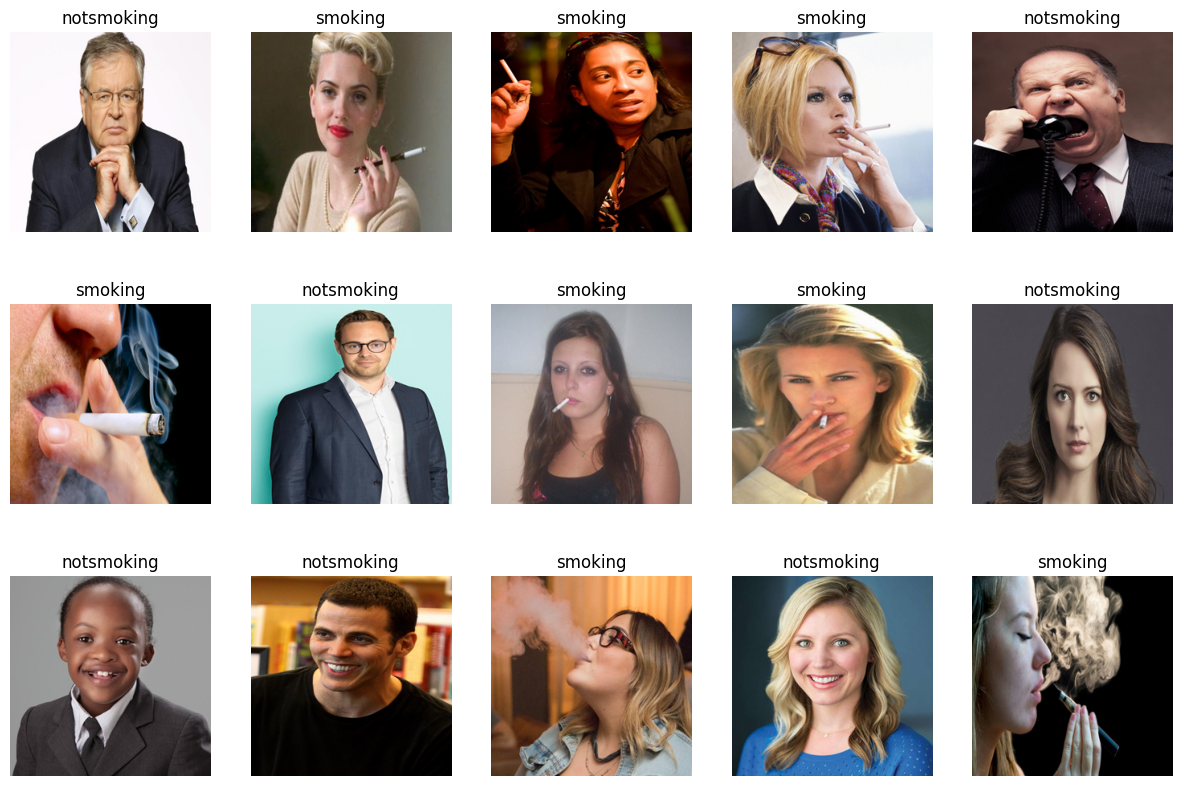

In [29]:
show_imgs = 15
idx = np.random.randint(0,len(val_df) , size = show_imgs)
fig , axes = plt.subplots(show_imgs // 5 , 5 , figsize = (15 , 10))
axes = axes.flatten()
for i , ax in enumerate(axes):
    full_path = val_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(val_df.loc[idx[i]]['label'])
    ax.set_axis_off()

## Dataset & Dataloader

Pytorch의 Dataset & Dataloader은, 데이터를 다루고 모델을 훈련 및 시험하기 위하여 가장 주의를 기울여야 될 부분 중의 하나입니다.

Dataset은 전체 데이터에서 특정 데이터를 꺼내오는 역할 및 전처리나 augmentation, 추가적인 function 처리를 효율적으로 할 수 있도록 합니다.
Dataloader의 경우, Dataset을 Minibatch 형태로 만들어 주며, Batch size나, Shuffle 여부에 대한 것들을 설정할 수 있습니다.

자세한 사항은 아래의 링크를 확인해보시기 바랍니다.

- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [30]:
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2

In [31]:
class BaseDataset(torch.utils.data.Dataset):
    def __init__(self , dataframe , transforms_):
        self.df = dataframe
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self ,index):
        img_path = self.df.iloc[index]['path']
        img = Image.open(img_path).convert("RGB")
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img , class_id

In [32]:
SimpleTransforms = v2.Compose([
    v2.Resize((224,224)), # image 크기 맞추기
    v2.PILToTensor(), # torch.tensor로 변환
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),]) # dtype 변환

In [33]:
BATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
example_dataset = BaseDataset(train_df , SimpleTransforms) # train_transforms
example_loader = DataLoader(example_dataset , batch_size=BATCH_SIZE , shuffle = True)

In [34]:
img, class_id = next(iter(example_dataset))

In [35]:
img.shape # (batch, channel, W, H)

torch.Size([3, 224, 224])

In [36]:
img, class_id = next(iter(example_loader))

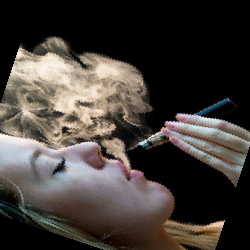

In [37]:
# augmentation 참고
# https://pytorch.org/vision/main/transforms.html

rotation_transform = v2.RandomRotation(degrees=90) # compose에 추가 가능
image = Image.open(full_path)
rotated_image = rotation_transform(image)
rotated_image


# 문제 2

 1-3의 모델을 **layer를 추가하지 않고**, 아래의 조건을 토대로 성능을
 향상시켜보세요.


 - batch norm, dropout 둘 다 적용
 - data augmentation 기법 1가지 이상 추가
 - layer 자체를 추가하는 것 이외의 다른 방법들 추가 적용 가능
    - kernel size 등등
    - max pooling은 layer로 취급하지 않음
    - 이외 추가적인 hyperparameter 변경 가능
    - feature size 당연히, 수정 가능
 - **test acc (75%) 이상 달성**

In [103]:
CustomTransforms = v2.Compose([
    #===============================#
    v2.RandomHorizontalFlip(),  # 이미지를 무작위로 수평 뒤집기
    v2.RandomRotation(10),  # 이미지를 -10도에서 10도 사이로 무작위로 회전
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 색상 조절
    v2.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
    #===============================#
    ]) # dtype 변환


In [104]:
#get dataloader

train_dataset = BaseDataset(train_df , CustomTransforms) # train_transforms
val_dataset = BaseDataset(val_df , CustomTransforms)
test_dataset = BaseDataset(test_df , CustomTransforms)
train_loader = DataLoader(train_dataset , batch_size=BATCH_SIZE , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset , batch_size=BATCH_SIZE)

In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()



        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(123008, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)


        # Define max pooling layer
        self.pool = nn.MaxPool2d(2, 2)


        #===============================================#
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.5)
        #===============================================#

    def forward(self, x):

        #===============================================#
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))  # BCELoss를 사용하기 때문에 마지막에 sigmoid 적용
        #===============================================#

        return x


In [106]:
ImpModel = ImprovedCNN()
ImpModel.cuda()

ImprovedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=123008, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [107]:
# Define train and test functions
def train(dataloader, model, loss_fn, optimizer, lr_scheduler=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    epoch_loss, epoch_correct = 0, 0

    for data_, target_ in dataloader:
        data_, target_ = data_.cuda(), target_.cuda().unsqueeze(1).float()

        # Forward pass
        output = model(data_)
        loss = loss_fn(output, target_)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_correct += ((output > 0.5) == target_).sum().item()

    if lr_scheduler is not None:
        lr_scheduler.step()

    return epoch_correct / size, epoch_loss / num_batches

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    epoch_loss, epoch_correct = 0, 0
    model.eval()  # evaluation dropout 연산시

    with torch.no_grad():  # grad 연산 X
        for data_, target_ in dataloader:
            data_, target_ = data_.cuda(), target_.cuda().unsqueeze(1).float()

            # Forward pass
            output = model(data_)
            loss = loss_fn(output, target_)

            epoch_loss += loss.item()
            epoch_correct += ((output > 0.5) == target_).sum().item()

    return epoch_correct / size, epoch_loss / num_batches

EPOCHS = 100
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.BCELoss()

# hyperparameter 추가 및 변경 가능 설정해보세요
# optimizer, lr_scheduler 변경 가능
#==============================#
# Optimizer and learning rate scheduler
optimizer = torch.optim.Adam(ImpModel.parameters(), lr=0.0005, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)  # Adjust on plateau

#==============================#

patience = 10
counter = 0
best_loss = np.inf

In [120]:
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   ImpModel ,
                                   criterion ,
                                   optimizer ,
                                   Cosine_lr_scheduler)

    val_acc , val_loss = test(val_loader , ImpModel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(ImpModel.state_dict() , "checkpoints/Improved_CNN_best.pth")
    else:
        counter+=1
    if counter >= patience:
        test_acc , val_loss = test(test_loader , ImpModel , criterion)
        print("Early stop !")
        print(test_acc)
        break

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:0     train_loss = 0.5535 , train_acc:0.7193     val_loss = 0.5695 , val_acc:0.7111     learning rate: 0.0005


  0%|          | 0/100 [00:13<?, ?it/s]

Early stop !
0.7857142857142857


# 문제 3: Pretrained model
사전 학습된 모델(Pretrained model)을 통해 위의 이미지 데이터를  흡연 여부를 판별고자 합니다.

이를 위해서 모델을 불러오고, 학습 및 검증하여 최종 성능을 평가하시오.

In [198]:
# pretrained 관련
import torch
import torchvision.transforms as v2
from torchvision import models

In [199]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 문제 3-1: Pretrained Model (backborn)모델 학습

아래의 `resnet18` 예제를 참고하여, `vgg16`의 pretrained model를 불러와 Smoke 탐지를 진행할 수 있도록 layer를 수정하시오.

- MyVGG16 Class를 완성하시오.
- Vgg16의 CNN layer들은 모두 frozen하시오.
- 추가적인 layer와 다양한 기법들을 추가해도 됩니다.
- **test acc (75%) 이상 달성**
- **(extra) test acc (80%) 이상 달성시 추가 점수(+1): freeze한 layer fine-tuning 가능**


- https://pytorch.org/vision/stable/models.html 참고

In [200]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [201]:
print(resnet18) # 각 레이어의 구성을 확인

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [202]:
Last_layer_hiddensize = resnet18.fc.in_features
resnet18.fc = nn.Linear(Last_layer_hiddensize, 1)

In [203]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

In [204]:
# nn.Linear(10,10).requires_grad = False # gradiant 끄기
# nn.Linear(10,10).requires_grad = True # gradiant 켜기

In [214]:
import torch.nn as nn
class MyVGG16(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(MyVGG16, self).__init__()
        self.backbone = pretrained_model.features

        #=============================#
        self.avgpool = pretrained_model.avgpool
        self.classifier = pretrained_model.classifier
        # Freeze all VGG16 layers
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Define the new classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1)  # Binary classification
        )
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(512, num_classes)
        self.new_layer = nn.Linear(num_classes, 2)  # 새로운 레이어 추가
        #=============================#
    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        x = self.sigmoid(x)
        return x

In [215]:
# GPU 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [216]:
myvgg16 = MyVGG16(vgg16, 10)  # 10개의 클래스

In [217]:
myvgg16.to(device)

MyVGG16(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

## 문제 3-2: Fine-tuning

- `MyVGG16`를 활용하여 Fine-tuning을 진행하시오.

In [218]:
EPOCHS = 100
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.BCELoss()

# hyperparameter 추가 및 변경 가능 설정해보세요
# optimizer, lr_scheduler 변경 가능
#==============================#
from torch.optim.lr_scheduler import CosineAnnealingLR
# Hyperparameters
lr = 0.01
momentum = 0.9
weight_decay = 1e-4

# Optimizer and LR Scheduler
optimizer = torch.optim.SGD(myvgg16.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
Cosine_lr_scheduler = CosineAnnealingLR(optimizer, T_max=100)

#==============================#

patience = 10
counter = 0
best_loss = np.inf

In [219]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train()
    epoch_loss , epoch_correct = 0 , 0

    #===================================================#
    for data_, target_ in dataloader:
        data_, target_ = data_.to(device), target_.view(-1, 1).float().to(device)

        optimizer.zero_grad()
        output = model(data_)
        loss = loss_fn(output, target_)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_correct += ((output > 0.5).float() == target_).type(torch.float).sum().item()


       #===================================================#

    train_acc = epoch_correct/size
    lr_scheduler.step()

    return train_acc , epoch_loss / num_batches


def test(dataloader , model , loss_fn):
    size = len(dataloader.dataset)
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad(): # grad 연산 X
        for data_, target_ in dataloader:
            data_, target_ = data_.to(device), target_.view(-1, 1).float().to(device)

            #========================================#

            output = model(data_)
            loss = loss_fn(output, target_)
            epoch_loss += loss.item()
            epoch_correct += ((output > 0.5).float() == target_).type(torch.float).sum().item()

            #========================================#

    test_acc = epoch_correct/size

    return test_acc  , epoch_loss / num_baches

In [220]:
myvgg16.cuda()

MyVGG16(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [221]:
for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(train_loader,
                                  myvgg16,
                                  criterion,
                                  optimizer,
                                  Cosine_lr_scheduler)

    val_acc, val_loss = test(val_loader, myvgg16, criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f}, train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f}, val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(myvgg16.state_dict(), "checkpoints/vgg_16_best.pth")
    else:
        counter += 1

    if counter >= patience:
        test_acc, test_loss = test(test_loader, myvgg16, criterion)
        print("Early stop!")
        print(test_acc)
        break

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:0     train_loss = 1.3403, train_acc:0.6299     val_loss = 0.7267, val_acc:0.7000     learning rate: 0.009997532801828659


  2%|▏         | 2/100 [00:31<25:10, 15.42s/it]

epoch:1     train_loss = 0.6804, train_acc:0.7416     val_loss = 0.8727, val_acc:0.7611     learning rate: 0.00999013364214136
epoch:2     train_loss = 0.5244, train_acc:0.8115     val_loss = 0.3693, val_acc:0.8611     learning rate: 0.009977809823015401


  4%|▍         | 4/100 [01:01<24:16, 15.17s/it]

epoch:3     train_loss = 0.4365, train_acc:0.8575     val_loss = 0.4632, val_acc:0.8333     learning rate: 0.009960573506572392


  5%|▌         | 5/100 [01:15<23:22, 14.76s/it]

epoch:4     train_loss = 0.3819, train_acc:0.8701     val_loss = 0.5814, val_acc:0.8056     learning rate: 0.00993844170297569


  6%|▌         | 6/100 [01:29<22:42, 14.49s/it]

epoch:5     train_loss = 0.3249, train_acc:0.8715     val_loss = 0.4381, val_acc:0.8556     learning rate: 0.009911436253643446
epoch:6     train_loss = 0.2453, train_acc:0.9218     val_loss = 0.3270, val_acc:0.8500     learning rate: 0.009879583809693738


  8%|▊         | 8/100 [02:02<23:22, 15.25s/it]

epoch:7     train_loss = 0.4854, train_acc:0.8911     val_loss = 0.5356, val_acc:0.8611     learning rate: 0.009842915805643155


  9%|▉         | 9/100 [02:16<22:35, 14.89s/it]

epoch:8     train_loss = 0.3550, train_acc:0.8925     val_loss = 0.6756, val_acc:0.8222     learning rate: 0.009801468428384716


 10%|█         | 10/100 [02:30<22:06, 14.74s/it]

epoch:9     train_loss = 0.2905, train_acc:0.9148     val_loss = 0.6308, val_acc:0.8167     learning rate: 0.009755282581475767


 11%|█         | 11/100 [02:44<21:38, 14.59s/it]

epoch:10     train_loss = 0.2731, train_acc:0.9232     val_loss = 0.6519, val_acc:0.8333     learning rate: 0.009704403844771127


 12%|█▏        | 12/100 [02:59<21:13, 14.47s/it]

epoch:11     train_loss = 0.2243, train_acc:0.9385     val_loss = 0.5405, val_acc:0.8667     learning rate: 0.009648882429441256


 13%|█▎        | 13/100 [03:13<20:48, 14.35s/it]

epoch:12     train_loss = 0.1957, train_acc:0.9330     val_loss = 0.5085, val_acc:0.8444     learning rate: 0.009588773128419903


 14%|█▍        | 14/100 [03:27<20:41, 14.44s/it]

epoch:13     train_loss = 0.1531, train_acc:0.9567     val_loss = 0.5250, val_acc:0.8889     learning rate: 0.009524135262330096


 15%|█▌        | 15/100 [03:41<20:12, 14.27s/it]

epoch:14     train_loss = 0.1833, train_acc:0.9344     val_loss = 0.4127, val_acc:0.9000     learning rate: 0.009455032620941838


 16%|█▌        | 16/100 [03:55<19:53, 14.21s/it]

epoch:15     train_loss = 0.0690, train_acc:0.9777     val_loss = 0.6317, val_acc:0.8944     learning rate: 0.009381533400219317
epoch:16     train_loss = 0.1114, train_acc:0.9693     val_loss = 0.2779, val_acc:0.9056     learning rate: 0.009303710135019717


 18%|█▊        | 18/100 [04:25<19:52, 14.54s/it]

epoch:17     train_loss = 0.1052, train_acc:0.9707     val_loss = 0.3567, val_acc:0.9167     learning rate: 0.009221639627510075


 19%|█▉        | 19/100 [04:39<19:26, 14.40s/it]

epoch:18     train_loss = 0.0635, train_acc:0.9804     val_loss = 0.4707, val_acc:0.8833     learning rate: 0.00913540287137281


 20%|██        | 20/100 [04:53<19:02, 14.28s/it]

epoch:19     train_loss = 0.1035, train_acc:0.9623     val_loss = 0.5786, val_acc:0.8778     learning rate: 0.009045084971874739


 21%|██        | 21/100 [05:07<18:41, 14.19s/it]

epoch:20     train_loss = 0.0929, train_acc:0.9777     val_loss = 0.5113, val_acc:0.8556     learning rate: 0.008950775061878451


 22%|██▏       | 22/100 [05:21<18:22, 14.13s/it]

epoch:21     train_loss = 0.0799, train_acc:0.9735     val_loss = 0.4597, val_acc:0.8889     learning rate: 0.008852566213878947


 23%|██▎       | 23/100 [05:35<18:05, 14.09s/it]

epoch:22     train_loss = 0.0568, train_acc:0.9832     val_loss = 0.9736, val_acc:0.8889     learning rate: 0.008750555348152299


 24%|██▍       | 24/100 [05:49<17:49, 14.08s/it]

epoch:23     train_loss = 0.0978, train_acc:0.9679     val_loss = 0.6860, val_acc:0.8778     learning rate: 0.00864484313710706


 25%|██▌       | 25/100 [06:04<17:36, 14.09s/it]

epoch:24     train_loss = 0.0577, train_acc:0.9804     val_loss = 0.8821, val_acc:0.9111     learning rate: 0.008535533905932738


 26%|██▌       | 26/100 [06:17<17:19, 14.05s/it]

epoch:25     train_loss = 0.0804, train_acc:0.9763     val_loss = 0.6436, val_acc:0.8444     learning rate: 0.008422735529643444
epoch:26     train_loss = 0.1272, train_acc:0.9623     val_loss = 0.5684, val_acc:0.8889     learning rate: 0.00830655932661826


 26%|██▌       | 26/100 [06:35<18:45, 15.21s/it]

Early stop!
0.8392857142857143


# 문제 4: 최종 결과 비교

- 각 BEST 모델을 불러오고 성능 비교 (ImprovedCNN best,VGG16 best)

In [236]:
model_state_dict = torch.load("checkpoints/Improved_CNN_best.pth")
ImpCNN = ImprovedCNN()
ImpCNN.load_state_dict(model_state_dict)

<All keys matched successfully>

In [237]:
import torchvision.models as models

# 사전 학습된 VGG16 모델 로드
pretrained_model = models.vgg16(pretrained=True)

# 분류할 클래스 수 설정
num_classes = 10

# MyVGG16 클래스 인스턴스 생성
myvgg16 = MyVGG16(pretrained_model, num_classes)

# 체크포인트 로드
model_state_dict = torch.load("checkpoints/vgg_16_best.pth")
myvgg16.load_state_dict(model_state_dict)


<All keys matched successfully>

In [244]:
models = {
    'imp_cnn': ImprovedCNN(),
    'my_vgg16': MyVGG16(pretrained_model, num_classes)
}

imp_test_acc = 0
vgg_test_acc = 0

for model_name, model_obj in models.items():
    correct = 0
    total = 0
    for data, target in test_loader:
        output = model_obj(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    if model_name == 'imp_cnn':
        imp_test_acc = 100 * correct / total
    elif model_name == 'my_vgg16':
        vgg_test_acc = 100 * correct / total

print(f"ImpCNN {imp_test_acc}")
print(f"MyVgg16 {vgg_test_acc}")


ImpCNN 50.0
MyVgg16 50.0
